100%|██████████| 2.00G/2.00G [01:12<00:00, 27.7MB/s] 


Extracting /kaggle/working/dataset_root/VOCtrainval_11-May-2012.tar to /kaggle/working/dataset_root
Using downloaded and verified file: /kaggle/working/dataset_root/VOCtrainval_11-May-2012.tar
Extracting /kaggle/working/dataset_root/VOCtrainval_11-May-2012.tar to /kaggle/working/dataset_root


Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 196MB/s] 


Epoch 1/10, Loss: 4.5086
Epoch 2/10, Loss: 3.4700
Epoch 3/10, Loss: 2.9973
Epoch 4/10, Loss: 2.6353
Epoch 5/10, Loss: 2.2610
Epoch 6/10, Loss: 1.9900
Epoch 7/10, Loss: 1.7709
Epoch 8/10, Loss: 1.5550
Epoch 9/10, Loss: 1.3466
Epoch 10/10, Loss: 1.1573
Detected 2 objects: [((118, 139, 412, 379), 0.9921232), ((136, 163, 213, 215), 0.90325797)]


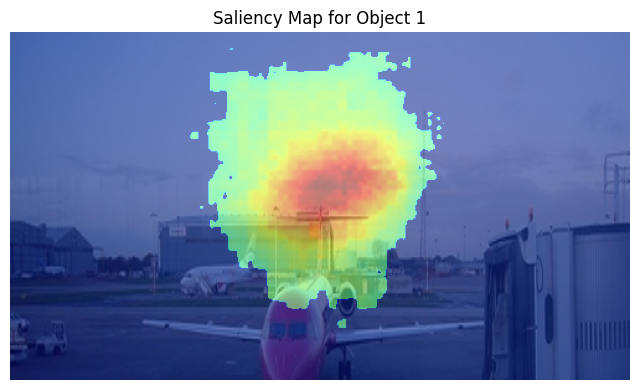

BODEM Insertion AUC: 0.9000
BODEM Deletion AUC: 0.1040
BODEM Convergence Metric: 0.6667


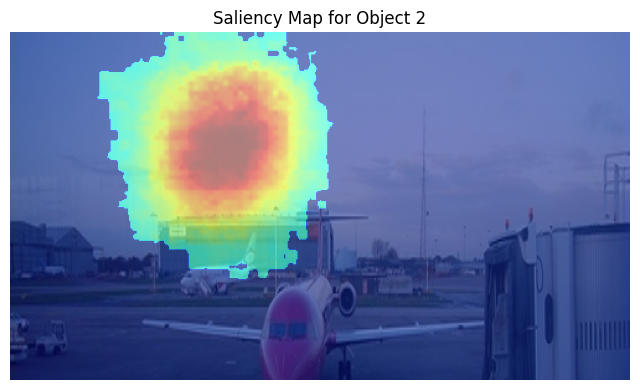

BODEM Insertion AUC: 0.9000
BODEM Deletion AUC: 0.0500
BODEM Convergence Metric: 0.6667


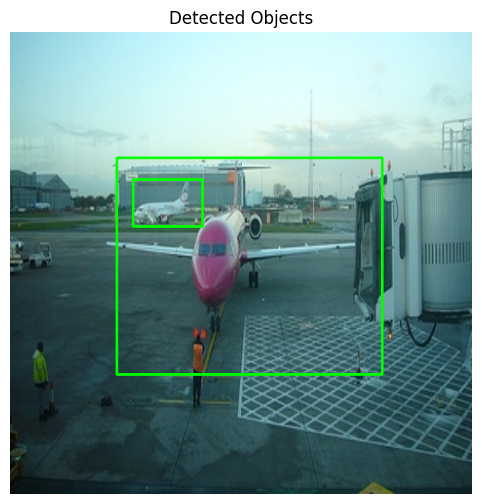

Process complete. Check displayed saliency maps, detected objects, and evaluation metrics.


In [1]:
import cv2
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import VOCDetection
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import random

# --- Configuration ---
DATASET_ROOT = '/kaggle/working/dataset_root'  # Update to where VOC will be downloaded (e.g., '/data/voc')
MODEL_PATH = '/kaggle/working/ssd_model.pth'
IMAGE_PATH = os.path.join(DATASET_ROOT, 'VOCdevkit', 'VOC2012', 'JPEGImages', '2007_000032.jpg')  # Example VOC image
EPOCHS = 10
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
    'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
NUM_CLASSES = len(VOC_CLASSES)  # 21 (20 classes + background)

# --- Data Section ---
def load_voc_dataset():
    """
    Load Pascal VOC 2012 dataset using VOCDetection.
    - Downloads VOC 2012 to DATASET_ROOT/VOCdevkit/VOC2012/ if download=True (~2GB).
    - Manual download: Get VOCtrainval_11-May-2012.tar from http://host.robots.ox.ac.uk/pascal/VOC/voc2012/,
      extract to DATASET_ROOT/VOCdevkit/, and set download=False.
    - Uses 'trainval' for training and 'val' for testing (VOC 2012 does not support 'test' in torchvision).
    """
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = VOCDetection(
        root=DATASET_ROOT,
        year='2012',
        image_set='trainval',
        download=True,  # Set to False if manually downloaded
        transform=transform
    )
    test_dataset = VOCDetection(
        root=DATASET_ROOT,
        year='2012',
        image_set='val',  # Changed from 'test' to 'val' as 'test' is not supported
        download=True,  # Set to False if manually downloaded
        transform=transform
    )
    return train_dataset, test_dataset

def voc_collate_fn(batch):
    """Convert VOC annotations to SSD-compatible format."""
    images = []
    targets = []
    for img, target in batch:
        images.append(img)
        boxes = []
        labels = []
        for obj in target['annotation']['object']:
            name = obj['name']
            if name not in VOC_CLASSES:
                continue
            bbox = obj['bndbox']
            boxes.append([
                float(bbox['xmin']),
                float(bbox['ymin']),
                float(bbox['xmax']),
                float(bbox['ymax'])
            ])
            labels.append(VOC_CLASSES.index(name))
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        targets.append({'boxes': boxes, 'labels': labels})
    return images, targets

# --- Object Detection Model Section ---
def train_ssd_model(dataset, num_classes):
    """
    Train SSD model on VOC dataset.
    - Downloads pre-trained weights (SSD300_VGG16_Weights.DEFAULT) automatically from PyTorch Hub.
    - Fine-tunes for VOC's 21 classes and saves to MODEL_PATH.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)  # Auto-downloads COCO weights
    model.head.classification_head.num_classes = num_classes
    model.to(device)
    
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, 
                            collate_fn=voc_collate_fn)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{'boxes': t['boxes'].to(device), 'labels': t['labels'].to(device)} 
                       for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            total_loss += losses.item()
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataloader):.4f}")
    
    torch.save(model.state_dict(), MODEL_PATH)
    return model

def detect(image, model, resize=True):
    """Perform object detection on a single image."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    if resize:
        image = cv2.resize(image, (512, 512))  # For BODEM compatibility
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = transforms.ToTensor()(image_rgb).to(device).unsqueeze(0)
    with torch.no_grad():
        detections = model(image_tensor)[0]
    boxes = detections['boxes'].cpu().numpy()
    scores = detections['scores'].cpu().numpy()
    threshold = 0.5
    filtered_indices = np.where(scores >= threshold)[0]
    filtered_boxes = boxes[filtered_indices]
    filtered_scores = scores[filtered_indices]
    return [(tuple(box.astype(int)), score) for box, score in zip(filtered_boxes, filtered_scores)]

# --- BODEM Explanation Section ---
def get_blocks(num_blocks_h, num_blocks_w):
    return [(i, j) for i in range(num_blocks_h) for j in range(num_blocks_w)]

def get_block_slice(block, BS):
    i, j = block
    return slice(i * BS, (i + 1) * BS), slice(j * BS, (j + 1) * BS)

def get_avg_saliency(SM, block, BS):
    slice_i, slice_j = get_block_slice(block, BS)
    return np.mean(SM[slice_i, slice_j])

def get_neighbors(block, l, num_blocks_h, num_blocks_w):
    i, j = block
    neighbors = []
    for di in range(-l, l + 1):
        for dj in range(-l, l + 1):
            if di == 0 and dj == 0:
                continue
            ni, nj = i + di, j + dj
            if 0 <= ni < num_blocks_h and 0 <= nj < num_blocks_w:
                neighbors.append((ni, nj))
    return neighbors

def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2
    xi1 = max(x1, x1_)
    yi1 = max(y1, y1_)
    xi2 = min(x2, x2_)
    yi2 = min(y2, y2_)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y1_)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def apply_mask(image, mask, BS):
    masked_image = image.copy()
    num_blocks_h, num_blocks_w = mask.shape
    for i in range(num_blocks_h):
        for j in range(num_blocks_w):
            if mask[i, j]:
                slice_i, slice_j = get_block_slice((i, j), BS)
                masked_image[slice_i, slice_j] = 0
    return masked_image

def get_confidence(image, model, original_box):
    detected = detect(image, model)
    if detected:
        ious = [iou(original_box, d_box[0]) for d_box in detected]
        max_iou = max(ious) if ious else 0
        if max_iou > 0.5:  # Consider it the same object
            idx = ious.index(max_iou)
            return detected[idx][1]  # Return confidence score
    return 0

def bodem_explanation(image, O_n, detect, L=6, K=128, alpha=0.5, beta=0.3):
    """Generate saliency map for a detected object using BODEM."""
    H, W = image.shape[:2]
    SM = np.zeros((H, W))
    for l in range(1, L + 1):
        BS = K // (2 ** (l - 1))
        num_blocks_h = H // BS
        num_blocks_w = W // BS
        blocks = get_blocks(num_blocks_h, num_blocks_w)
        if l == 1:
            CS = set(blocks)
        else:
            CS = {b_p for b_p in blocks if get_avg_saliency(SM, b_p, BS) > 0}
        salient_blocks = CS.copy()
        masked_blocks = set()
        M_l = []
        while CS:
            if l > 1 and salient_blocks.issubset(masked_blocks):
                break
            if l == 1:
                seed = random.choice(list(CS))
            else:
                weights = [get_avg_saliency(SM, b_p, BS) for b_p in CS]
                weights = [w if w > 0 else 1e-6 for w in weights]  # Avoid zero weights
                seed = random.choices(list(CS), weights=weights, k=1)[0]
            neighbors = get_neighbors(seed, l, num_blocks_h, num_blocks_w)
            num_to_select = max(1, len(neighbors) // 2)
            selected_neighbors = random.sample(neighbors, min(num_to_select, len(neighbors)))
            mask = np.zeros((num_blocks_h, num_blocks_w), dtype=bool)
            mask_blocks = [seed] + selected_neighbors
            for b in mask_blocks:
                mask[b] = True
            M_l.append(mask)
            masked_blocks.update(mask_blocks)
            CS.remove(seed)
        IS_dict = defaultdict(list)
        for mask in M_l:
            masked_image = apply_mask(image, mask, BS)
            detected_boxes = detect(masked_image)
            if detected_boxes:
                ious = [iou(O_n, box[0]) for box in detected_boxes]
                max_iou = max(ious) if ious else 0
                similarity = max_iou
            else:
                similarity = 0
            IS = 1 - similarity
            for i in range(num_blocks_h):
                for j in range(num_blocks_w):
                    if mask[i, j] and IS > 0.1:  # Only consider significant changes
                        IS_dict[(i, j)].append(IS)
        OIS = {}
        for b_p in blocks:
            if b_p in IS_dict:
                OIS[b_p] = np.mean(IS_dict[b_p])
            else:
                OIS[b_p] = 0
        for b_p in blocks:
            if l == 1:
                value = OIS[b_p]
            elif get_avg_saliency(SM, b_p, BS) > 0:
                if b_p in masked_blocks and OIS[b_p] > 0:
                    value = alpha * get_avg_saliency(SM, b_p, BS) + (1 - alpha) * OIS[b_p]
                else:
                    value = beta * get_avg_saliency(SM, b_p, BS)
            else:
                continue
            slice_i, slice_j = get_block_slice(b_p, BS)
            SM[slice_i, slice_j] = value
    
    # Normalize and highlight the saliency map
    if SM.max() > SM.min():
        SM_normalized = (SM - SM.min()) / (SM.max() - SM.min())
    else:
        SM_normalized = SM  # Avoid division by zero
    SM_smooth = cv2.GaussianBlur(SM_normalized, (5, 5), 0)
    threshold = np.percentile(SM_smooth, 80)
    SM_highlighted = np.where(SM_smooth > threshold, SM_smooth, 0)
    
    return SM_highlighted

def evaluate_bodem(image, saliency_map, original_box, detect, model, L=6, K=128, alpha=0.5, beta=0.3):
    H, W = image.shape[:2]
    
    # Normalize saliency map for evaluation
    saliency_map_normalized = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-10)
    
    # Sort pixels by saliency value (descending)
    sorted_indices = np.argsort(saliency_map_normalized.flatten())[::-1]
    total_pixels = H * W
    steps = 10  # Number of steps for insertion/deletion
    step_size = total_pixels // steps

    # Insertion Metric: Add pixels from most salient to least
    insertion_confidences = []
    masked_image = np.zeros_like(image)
    for i in range(0, total_pixels, step_size):
        indices = sorted_indices[:i]
        masked_image = image.copy()
        for idx in indices:
            y, x = divmod(idx, W)
            masked_image[y, x] = image[y, x]
        confidence = get_confidence(masked_image, model, original_box[0])
        insertion_confidences.append(confidence)
    # Compute AUC for insertion
    insertion_auc = np.trapz(insertion_confidences) / (max(insertion_confidences) * steps) if max(insertion_confidences) > 0 else 0
    print(f"BODEM Insertion AUC: {insertion_auc:.4f}")

    # Deletion Metric: Remove pixels from most salient to least
    deletion_confidences = []
    masked_image = image.copy()
    for i in range(0, total_pixels, step_size):
        indices = sorted_indices[:i]
        for idx in indices:
            y, x = divmod(idx, W)
            masked_image[y, x] = 0
        confidence = get_confidence(masked_image, model, original_box[0])
        deletion_confidences.append(confidence)
    # Compute AUC for deletion (reverse order for decreasing confidence)
    deletion_auc = np.trapz(deletion_confidences[::-1]) / (max(deletion_confidences) * steps) if max(deletion_confidences) > 0 else 0
    print(f"BODEM Deletion AUC: {deletion_auc:.4f}")

    # Convergence Metric: Compare saliency maps across layers
    convergence_values = []
    SM_previous = np.zeros((H, W))
    for l in range(1, L + 1):
        BS = K // (2 ** (l - 1))
        num_blocks_h = H // BS
        num_blocks_w = W // BS
        blocks = get_blocks(num_blocks_h, num_blocks_w)
        if l == 1:
            CS = set(blocks)
        else:
            CS = {b_p for b_p in blocks if get_avg_saliency(SM_previous, b_p, BS) > 0}
        salient_blocks = CS.copy()
        masked_blocks = set()
        M_l = []
        while CS:
            if l > 1 and salient_blocks.issubset(masked_blocks):
                break
            if l == 1:
                seed = random.choice(list(CS))
            else:
                weights = [get_avg_saliency(SM_previous, b_p, BS) for b_p in CS]
                weights = [w if w > 0 else 1e-6 for w in weights]
                seed = random.choices(list(CS), weights=weights, k=1)[0]
            neighbors = get_neighbors(seed, l, num_blocks_h, num_blocks_w)
            num_to_select = max(1, len(neighbors) // 2)
            selected_neighbors = random.sample(neighbors, min(num_to_select, len(neighbors)))
            mask = np.zeros((num_blocks_h, num_blocks_w), dtype=bool)
            mask_blocks = [seed] + selected_neighbors
            for b in mask_blocks:
                mask[b] = True
            M_l.append(mask)
            masked_blocks.update(mask_blocks)
            CS.remove(seed)
        IS_dict = defaultdict(list)
        for mask in M_l:
            masked_image = apply_mask(image, mask, BS)
            detected_boxes = detect(masked_image)
            if detected_boxes:
                ious = [iou(original_box[0], box[0]) for box in detected_boxes]
                max_iou = max(ious) if ious else 0
                similarity = max_iou
            else:
                similarity = 0
            IS = 1 - similarity
            for i in range(num_blocks_h):
                for j in range(num_blocks_w):
                    if mask[i, j] and IS > 0.1:
                        IS_dict[(i, j)].append(IS)
        SM_layer = np.zeros((H, W))
        OIS = {}
        for b_p in blocks:
            if b_p in IS_dict:
                OIS[b_p] = np.mean(IS_dict[b_p])
            else:
                OIS[b_p] = 0
        for b_p in blocks:
            if l == 1:
                value = OIS[b_p]
            elif get_avg_saliency(SM_layer, b_p, BS) > 0:
                if b_p in masked_blocks and OIS[b_p] > 0:
                    value = alpha * get_avg_saliency(SM_layer, b_p, BS) + (1 - alpha) * OIS[b_p]
                else:
                    value = beta * get_avg_saliency(SM_layer, b_p, BS)
            else:
                continue
            slice_i, slice_j = get_block_slice(b_p, BS)
            SM_layer[slice_i, slice_j] = value
        # Normalize SM_layer for comparison
        if SM_layer.max() > SM_layer.min():
            SM_layer_normalized = (SM_layer - SM_layer.min()) / (SM_layer.max() - SM_layer.min())
        else:
            SM_layer_normalized = SM_layer
        # Compute difference between consecutive layers
        convergence_values.append(np.mean(np.abs(SM_layer_normalized - SM_previous)))
        SM_previous = SM_layer_normalized
    # Compute convergence score (closer to 1 means better convergence)
    convergence = 1 - np.mean(convergence_values) / max(convergence_values) if max(convergence_values) > 0 else 1
    print(f"BODEM Convergence Metric: {convergence:.4f}")

# --- Main Execution ---
if __name__ == "__main__":
    # Load dataset
    train_dataset, test_dataset = load_voc_dataset()

    # Train model
    model = train_ssd_model(train_dataset, NUM_CLASSES)

    # Load model for inference
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
    else:
        print(f"Model file {MODEL_PATH} not found. Using newly trained model.")
    model.to(device)

    # Load test image
    image = cv2.imread(IMAGE_PATH)
    if image is None:
        raise ValueError(f"Failed to load image at {IMAGE_PATH}")

    # Detect objects
    detected_boxes = detect(image, model)
    print(f"Detected {len(detected_boxes)} objects: {detected_boxes}")

    # Generate saliency maps and evaluate
    for i, (box, score) in enumerate(detected_boxes):
        saliency_map = bodem_explanation(image, box, lambda img: detect(img, model))
        
        # Convert image to RGB for plotting
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_rgb = cv2.resize(image_rgb, (512, 512))
        
        # Overlay saliency map on the original image
        plt.figure(figsize=(8, 6))
        plt.imshow(image_rgb)
        plt.imshow(saliency_map, cmap='jet', alpha=0.5)  # Overlay with transparency
        plt.title(f"Saliency Map for Object {i+1}")
        plt.axis('off')
        plt.show()

        # Evaluate BODEM saliency map
        evaluate_bodem(image, saliency_map, (box, score), lambda img: detect(img, model), model)

    # Display image with bounding boxes
    image_with_boxes = image.copy()
    image_with_boxes = cv2.resize(image_with_boxes, (512, 512))
    for (x1, y1, x2, y2), _ in detected_boxes:
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title("Detected Objects")
    plt.axis('off')
    plt.show()

    print("Process complete. Check displayed saliency maps, detected objects, and evaluation metrics.")